In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
milk = pd.read_csv('monthly-milk-production.csv',index_col='Month')

In [3]:
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [4]:
milk.index = pd.to_datetime(milk.index)

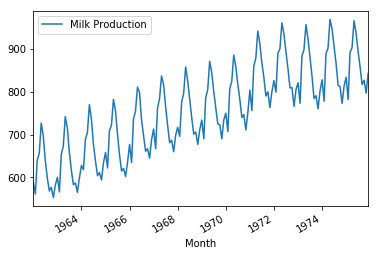

In [5]:
milk.plot()

In [6]:
train_set = milk.head(156)
test_set = milk.tail(12)

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

In [8]:
def next_batch(training_data,batch_size,steps):
    
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps) 

    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)

    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

In [9]:
import tensorflow as tf

In [10]:
# Just one feature, the time series
num_inputs = 1
# Num of steps in each batch
num_time_steps = 12
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1

## You can also try increasing iterations, but decreasing learning rate
# learning rate you can play with this
learning_rate = 0.03 
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 4000
# Size of the batch of data
batch_size = 1

In [11]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [12]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs) 

In [13]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [14]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [15]:
init = tf.global_variables_initializer()

In [16]:
saver = tf.train.Saver()

In [17]:
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./ex_time_series_model")

0 	MSE: 0.766391
100 	MSE: 0.0143402
200 	MSE: 0.013933
300 	MSE: 0.0120604
400 	MSE: 0.0091847
500 	MSE: 0.0206638
600 	MSE: 0.00684242
700 	MSE: 0.0127189
800 	MSE: 0.00898336
900 	MSE: 0.00872412
1000 	MSE: 0.00953092
1100 	MSE: 0.00578542
1200 	MSE: 0.00281234
1300 	MSE: 0.0102712
1400 	MSE: 0.0072358
1500 	MSE: 0.00555705
1600 	MSE: 0.00366082
1700 	MSE: 0.0081135
1800 	MSE: 0.00558129
1900 	MSE: 0.0104283
2000 	MSE: 0.00717311
2100 	MSE: 0.0114893
2200 	MSE: 0.00773861
2300 	MSE: 0.00473481
2400 	MSE: 0.00469087
2500 	MSE: 0.00870423
2600 	MSE: 0.00344487
2700 	MSE: 0.005137
2800 	MSE: 0.00407431
2900 	MSE: 0.00414899
3000 	MSE: 0.00271137
3100 	MSE: 0.0042036
3200 	MSE: 0.00324548
3300 	MSE: 0.00698266
3400 	MSE: 0.00828606
3500 	MSE: 0.00145392
3600 	MSE: 0.0151531
3700 	MSE: 0.00296493
3800 	MSE: 0.00139384
3900 	MSE: 0.0095353


In [18]:
test_set

,Milk Production
Month,
1975-01-01 01:00:00,834.0
1975-02-01 01:00:00,782.0
1975-03-01 01:00:00,892.0
1975-04-01 01:00:00,903.0
1975-05-01 01:00:00,966.0
1975-06-01 01:00:00,937.0
1975-07-01 01:00:00,896.0
1975-08-01 01:00:00,858.0
1975-09-01 01:00:00,817.0


In [19]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [20]:
# with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./ex_time_series_model")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
    train_seed = list(train_scaled[-12:])
    
    ## Now create a for loop that 
    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./ex_time_series_model


In [21]:
train_seed

[array([ 0.66105769]),
 array([ 0.54086538]),
 array([ 0.80769231]),
 array([ 0.83894231]),
 array([ 1.]),
 array([ 0.94711538]),
 array([ 0.85336538]),
 array([ 0.75480769]),
 array([ 0.62980769]),
 array([ 0.62259615]),
 array([ 0.52884615]),
 array([ 0.625]),
 0.71445805,
 0.68778169,
 0.91026711,
 0.94040096,
 1.0395992,
 0.93291116,
 0.85957694,
 0.77750707,
 0.72673649,
 0.71795309,
 0.73136258,
 0.79799134]

In [22]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

In [23]:
test_set['Generated'] = results

/Users/katari/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
test_set

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,850.214478
1975-02-01 01:00:00,782.0,839.117188
1975-03-01 01:00:00,892.0,931.671082
1975-04-01 01:00:00,903.0,944.206848
1975-05-01 01:00:00,966.0,985.473267
1975-06-01 01:00:00,937.0,941.091003
1975-07-01 01:00:00,896.0,910.583984
1975-08-01 01:00:00,858.0,876.442932
1975-09-01 01:00:00,817.0,855.322388


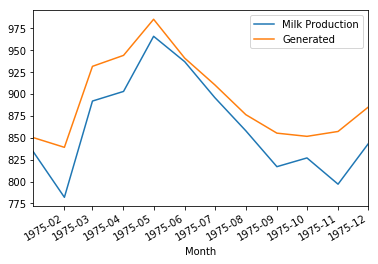

In [25]:
test_set.plot()